In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

## 0. Define file path

In [2]:
path = 'G:\\Data\\Qudi_Data\\2023\\12\\20231210\\AttoDRY2200_Pi3_SPM\\'
#here the beginning of the filename, including the date and sample name, is needed
filebeginning = '20231210-0029-08_scan54_laser_0.06V_linecut_long_24mT_Bnv_left_edge_3.1K_autosave_NbSe2_S2_A-T17-12_' 
filepath = path + filebeginning

## 1. Load data from pickle

In [3]:
with open(filepath+'qafm_array_raw.pickle', 'rb') as f:
    qafm_data = pickle.load(f)
with open(filepath+'pulsed_array_raw.pickle', 'rb') as f:
    pulsed_data = pickle.load(f)

In [101]:
# qafm_data = afm_scanner_logic._qafm_scan_array.copy()
# pulsed_data = afm_scanner_logic._pulsed_scan_array.copy()

In [104]:
# with open(filepath+"AUTOSAVE1.pickle", 'wb') as f:
#     pickle.dump(qafm_data, f)
# with open(filepath+"AUTOSAVE2.pickle", 'wb') as f:
#     pickle.dump(pulsed_data, f)

## 2. Determine bias field

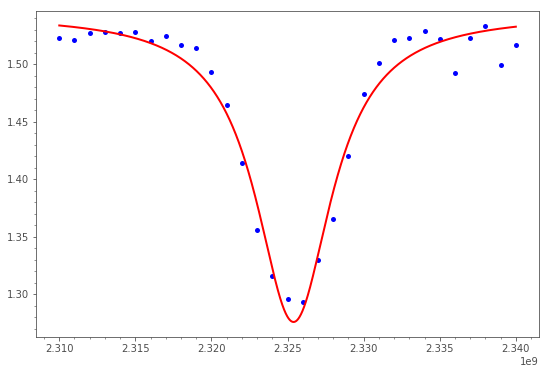

0.01980731795016401 T
6.083364763474987 MHz


In [4]:
#Analyse bias field
#Gathering data from dictonary
directory = 'G:\\Data\\Qudi_Data\\2023\\12\\20231208\\PODMR\\'
podrm_path = directory + '20231208-1548-08_scan_54_24mtBNV_FC_temp_3.1K_OOC_0.06V_ODMR_data_ch0_range0'+'.dat'
data_raw = np.loadtxt(podrm_path).T
var_list,data = (data_raw[0],data_raw[1])

gyro_nv = 28e9 #in Hz/T
e_field = 0 #in Hz
zero_field = 2.88e9 #in Hz, watch the Temperature

mode = ''
gslac = False
left = True

#Determine fit

if mode == 'double':
    fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_dip)
    lm,_ = fitlogic.make_lorentziandouble_model()
    
elif mode == 'N15':
    fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_N15)
    lm,_ = fitlogic.make_lorentziandouble_model()
    
elif mode == 'N14':
    fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_N14)
    lm,_ = fitlogic.make_lorentziandouble_model()
    
else:    
    fit = afm_scanner_logic._fitlogic.make_lorentzian_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentzian_dip)
    lm,_ = fitlogic.make_lorentzian_model()

# print(fit.fit_report())
bias_res_freq = fit.params['center'].value

if gslac == True and left == True:
    b_field_bias = np.sqrt(abs(bias_res_freq + zero_field)**2 - e_field**2) / gyro_nv
else:
    b_field_bias = np.sqrt(abs(bias_res_freq - zero_field)**2 - e_field**2) / gyro_nv

#Plot Data an
plt.plot(var_list,data,'bo')

x = np.linspace(var_list[0],var_list[-1],10000, endpoint=True)
plt.plot(x, lm.eval(fit.params, x=x),'r-')

plt.show()
fwhm_bias = fit.params['fwhm'].value*1e-6 #FWHM in MHz
print(b_field_bias,'T')
print(fwhm_bias,'MHz')

## 3. Fit full scan with chosen lorentzian (expensive-ish)

In [5]:
#Analyse scan with PODMR
#Gathering data from dictonary

data = pulsed_data['pulsed_fw']['data'][:,:]
var_list = pulsed_data['pulsed_fw']['coord2_arr']
coord0_num = qafm_data['Height(Dac)_fw']['params']['coord0_num (#)']
coord1_num = qafm_data['Height(Dac)_fw']['params']['coord1_num (#)']
res_freq = np.zeros((coord1_num,coord0_num))
fwhm = np.zeros((coord1_num,coord0_num))
fwhm_err = np.zeros((coord1_num,coord0_num))
b_field = np.zeros((coord1_num,coord0_num))
contrast = np.zeros((coord1_num,coord0_num))
contrast_err = np.zeros((coord1_num,coord0_num))
error_array = np.zeros((coord1_num,coord0_num))

#Define parameters for magnetic field calculation
gyro_nv = 28e9 #in Hz/T
e_field = 0 #in Hz
zero_field = 2.88e9 #in Hz, watch the Temperature

#Define the measured peak properties
mode = 'lorentzian'
gslac = False
left = True

for i in range(coord1_num):
    for j in range(coord0_num):
        
        #Determine fit
        try:
            if mode == 'double':
                fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data[i,j],estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_dip)
                res_freq[i,j] = fit.params['l0_center'].value + (fit.params['l1_center'].value-fit.params['l0_center'].value)/2
                
            elif mode == 'N15':
                fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data[i,j],estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_N15)
                res_freq[i,j] = fit.params['l0_center'].value + (fit.params['l1_center'].value-fit.params['l0_center'].value)/2
                
            elif mode == 'N14':
                fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data[i,j],estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_N14)
                res_freq[i,j] = fit.params['l0_center'].value
            else:    
                fit = afm_scanner_logic._fitlogic.make_lorentzian_fit(var_list,data[i,j],estimator=afm_scanner_logic._fitlogic.estimate_lorentzian_dip)
                lm,_ = fitlogic.make_lorentzian_model()
                res_freq[i,j] = fit.params['center'].value
                fwhm[i,j] = fit.params['fwhm'].value*1e-6 #FWHM in MHz#
                fwhm_err[i,j] = fit.params['fwhm'].stderr*1e-6 #FWHM in MHz
                contrast[i,j] = fit.params['contrast'].value*-1
                contrast_err[i,j] = fit.params['contrast'].stderr
        
        except:
            error_array[i,j] = 1
#        # EXPESNIVE
#         plt.plot(var_list,data[i,j],'bo',label=f'({i,j})')
#         x = np.linspace(var_list[0],var_list[-1],10000, endpoint=True)
#         plt.plot(x, lm.eval(fit.params, x=x),'r-',label=leg)
#         plt.legend()
#         plt.show()
            
if gslac == True and left == True:
    b_field = np.sqrt(abs(res_freq + zero_field)**2 - e_field**2) / gyro_nv
else:
    b_field = np.sqrt(abs(res_freq - zero_field)**2 - e_field**2) / gyro_nv

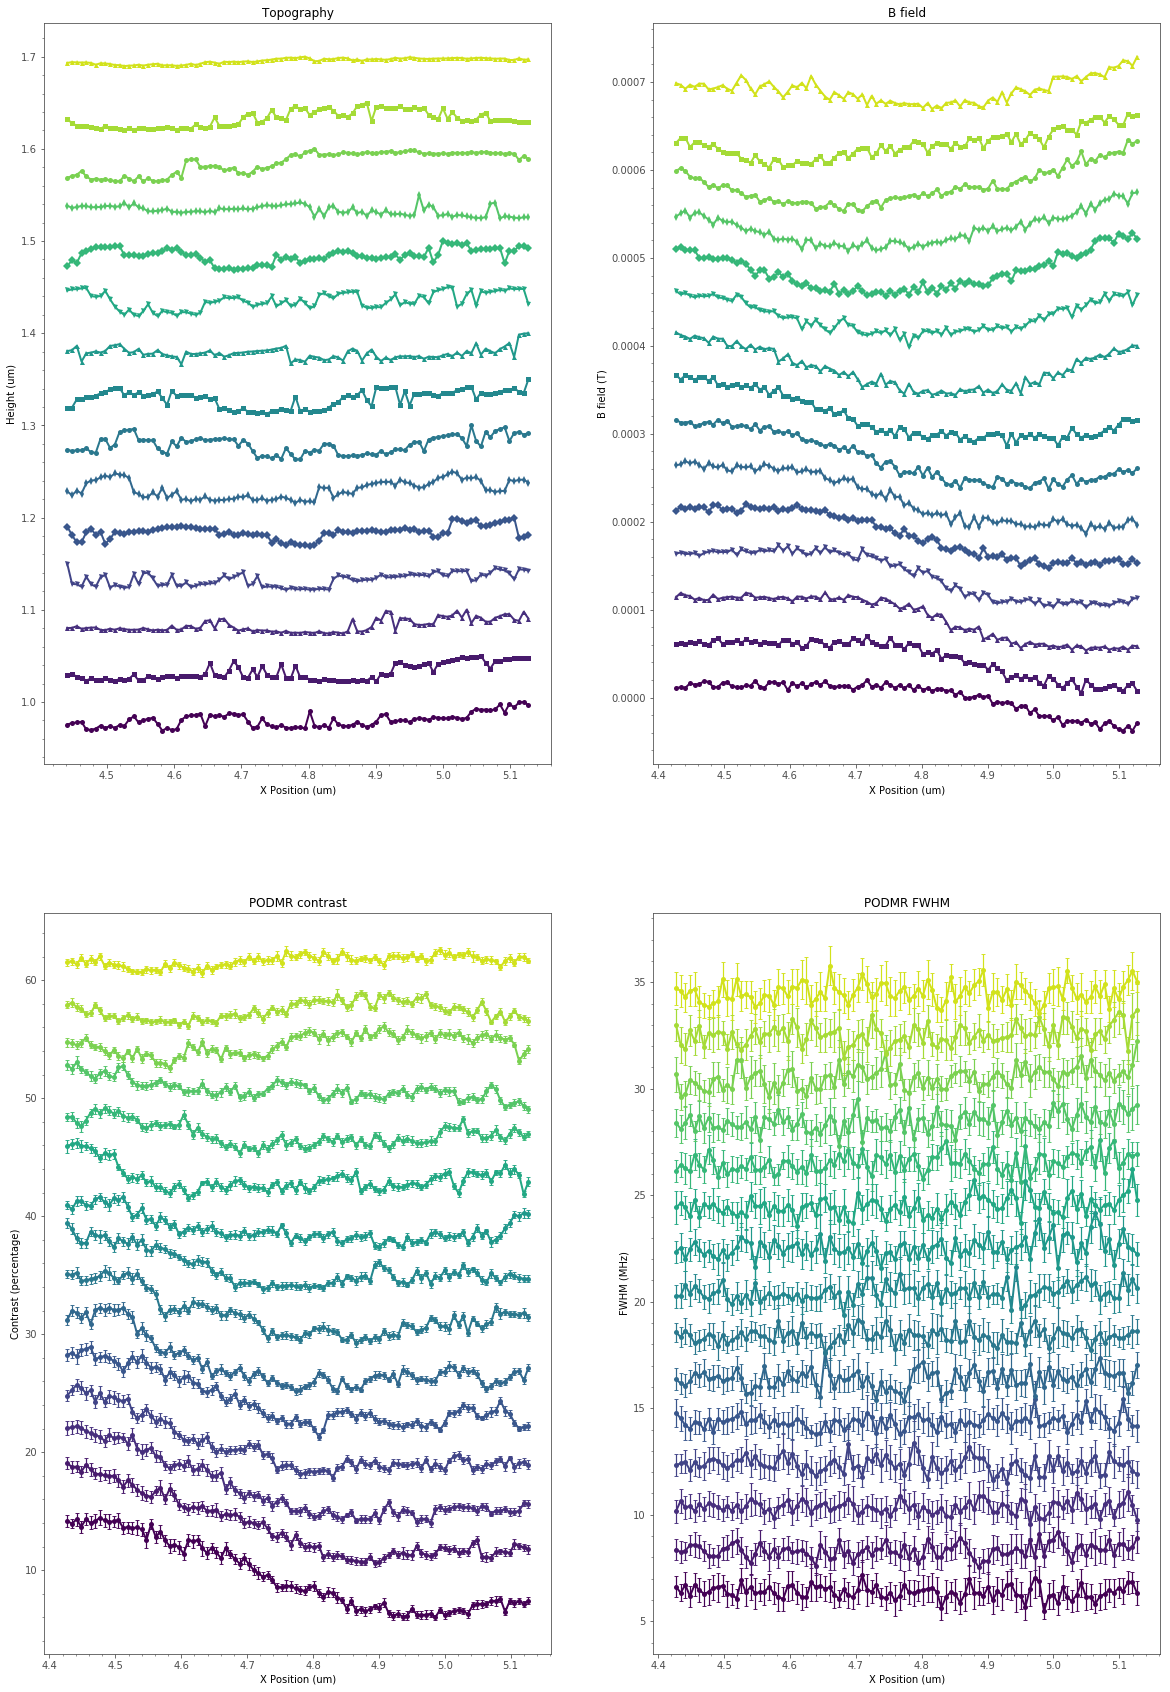

In [8]:
import matplotlib

cmap = matplotlib.cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin=0, vmax=coord1_num)


x = qafm_data['Height(Dac)_fw']['coord0_arr']*1e6
topo = qafm_data['Height(Dac)_fw']['data']*10**6
counts = qafm_data['counts_fw']['data']
shift = 0.3
figure, axis = plt.subplots(2, 2, figsize=(20,30)) 
for row in range(coord1_num):
    #colormap possible values = viridis, jet, spectral
    rgba = cmap(norm(row))

    axis[0,0].plot(x[2:], topo[row][2:]/np.max(topo[row][2:]) + (row*0.05), color=rgba)
    axis[0,0].set_xlabel('X Position (um)')
    axis[0,0].set_ylabel('Height (um)')
    axis[0,0].set_title("Topography")

    #axis[0,1].plot(x,counts[row])
    #axis[0,1].set_xlabel('X Position (um)')
    #axis[0,1].set_ylabel('Counts (#/s)')
    #axis[0,1].set_title('Counts')
    
    axis[0,1].plot(x, b_field[row]-b_field_bias + (row*50e-6), color=rgba)
    axis[0,1].set_xlabel('X Position (um)')
    axis[0,1].set_ylabel('B field (T)')
    axis[0,1].set_title('B field')

    #fit = afm_scanner_logic._fitlogic.make_decayexponentialstretched_fit(x_fit0,b_field[0]-b_field_bias,estimator=afm_scanner_logic._fitlogic.estimate_decayexponentialstretched)
    #lm,_ = fitlogic.make_decayexponentialstretched_model()
    #x_fit = np.linspace(x_fit0[0],x_fit0[-1],10000, endpoint=True)
    #leg = f"Lifetime: {round(fit.params['lifetime'].value,2)}u +- {round(fit.params['lifetime'].stderr,2)}u"
    # plt.plot(x_fit, lm.eval(fit.params, x=x_fit),'b-')

    axis[1,0].errorbar(x=x, y=contrast[row] + (row*4),
                     yerr=contrast_err[row], fmt='-o', color=rgba,
                     capsize=2, capthick=0.9,
                     elinewidth=1.2)
    axis[1,0].set_xlabel('X Position (um)')
    axis[1,0].set_ylabel('Contrast (percentage)')
    axis[1,0].set_title('PODMR contrast')
    
   
    axis[1,1].errorbar(x=x, y=fwhm[row] + (row*2),
                     yerr=fwhm_err[row], fmt='-o', color=rgba,
                     capsize=2, capthick=0.9,
                     elinewidth=1.2)
    axis[1,1].set_xlabel('X Position (um)')
    axis[1,1].set_ylabel('FWHM (MHz)')
    axis[1,1].set_title('PODMR FWHM')

plt.show()

FFT of signal

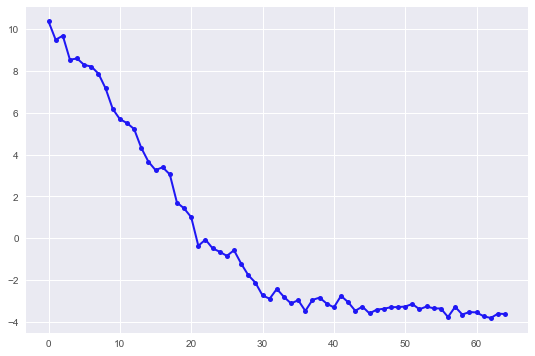

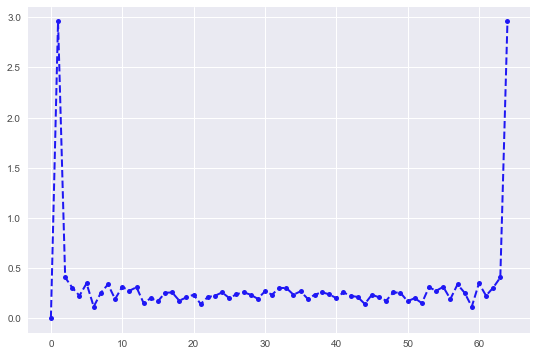

In [36]:
y_signal = contrast[1].copy()[60:]
y_signal -= y_signal.mean()
# T = 1/len(x_axis) / mod_freq #time array is defined to achieve said mod freq. For real, T would be the integration time or bin width
N = len(y_signal)
plt.plot(y_signal)
plt.show()

yf = fft(y_signal)
# xf = fftfreq(N, T)
yplot = 2.0/N* (yf)

plt.plot((yplot[:]),'o--')
plt.show()

In [9]:
topography = topo[0].copy()
field = (b_field[0]-b_field_bias).copy()
linewidth = fwhm[0].copy()
linewidth_err = fwhm_err[0].copy()
x_um = (x_gwy*10**6).copy()

### Fitting the linewidth data

In [10]:
fit = afm_scanner_logic._fitlogic.make_lorentzian_fit(x_um,linewidth,estimator=afm_scanner_logic._fitlogic.estimate_lorentzian_peak)
lm,_ = fitlogic.make_lorentzian_model()
print('center',fit.params['center'].value)
print('fwhm (nm)',fit.params['fwhm'].value*1e3) #FWHM in MHz#
print('fwhm err (nm)', fit.params['fwhm'].stderr*1e3) #FWHM in MHz

hwhm = round(fit.params["fwhm"].value*1e3/2,2)
hwhm_err = round(fit.params["fwhm"].stderr*1e3/2,2)

plt.style.use('default')
fig, ax1 = plt.subplots()

color1 = (80/255,80/255,255/255)
color2 = (255/255,80/255,80/255)

ax2 = ax1.twinx()
ax1.errorbar(x=x_um-5.6, y=linewidth,
                 yerr=linewidth_err, fmt='-o', color=color1,
                 capsize=2, capthick=0.9,
                 elinewidth=1.2)

ax2.plot(x_um-5.6,field*1e6,color=color2)

ax1.set_xlabel('Dist.($\mu$m)')
ax1.set_ylabel('PODMR Linewidth (MHz)', color=color1)
ax2.set_ylabel('Stray field (uT)', color=color2)

############Plot fit
x = np.linspace(x_um[0],x_um[-1],10000, endpoint=True)
ax1.plot(x-5.6, lm.eval(fit.params, x=x),'-', color='k',label = 'Fit', linewidth = 0.7)

############## Get data from below
x = np.linspace(x_um_fit[0],x_um_fit[-1],1000, endpoint=True)
ax2.plot(x-5.6, gmodel.eval(result.params, rho=x*1e-6)*1e6, color='k', linewidth = 0.7)


plt.xlim(5.6-5.6,6.6-5.6)
ax1.legend()
# plt.show()



# # plt.plot(x_um,linewidth,'bo',label=f'Linewidth')
# plt.errorbar(x=x_um, y=linewidth,
#                  yerr=linewidth_err, fmt='o', color='blue',
#                  capsize=2, capthick=0.9,
#                  elinewidth=1.2,label=f'Linewidth')


# x = np.linspace(x_um[0],x_um[-1],10000, endpoint=True)
# plt.plot(x, lm.eval(fit.params, x=x),'r-', label = f'Lorentzian HWHM = {hwhm} nm +- {hwhm_err} nm')

# plt.xlabel('X (um)')
# plt.ylabel('PODMR Linewidth (MHz)')

# plt.legend()
# plt.rcParams['figure.figsize'] = (9, 6)
# fontsize = 12
# # with open(filepath+f'_jupyter_plot_linewidth.png', 'wb') as f:
# #     plt.savefig(f,format='png',dpi=400)
# plt.show()






# plt.plot(x_um,field*1e6,'bo')

# plt.xlabel('X (um)')
# plt.ylabel('Stray field (uT)')

# plt.legend()
# plt.rcParams['figure.figsize'] = (9, 6)
# fontsize = 12
# with open(filepath+f'_jupyter_plot_combined.svg', 'wb') as f:
#     plt.savefig(f,format='svg',dpi=700)
# plt.show()

center 6.262212449268095
fwhm (nm) 20.253164751117545
fwhm err (nm) 32.88971530083266


### Modelling and fitting of vortex field data

In [56]:
from scipy.constants import h, c, e
from scipy.special import kn

def b(rho, delta_rho, eta, lmda, offset):
    R = np.sqrt((rho-delta_rho)**2+eta**2)
    phi_0 = h*1/(2*e) #T*m**2
    bz = (phi_0/(2*np.pi*lmda*eta))*kn(0,R/lmda)/kn(1,eta/lmda)+offset
    bx = np.zeros_like(bz)
    by = np.zeros_like(bz)
    return np.array([bx,by,bz]).T

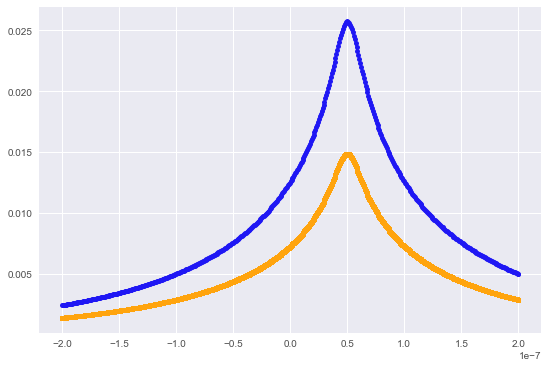

In [91]:
eta = 10e-9
lmda = 200e-9
rho = np.linspace(-200e-9,200e-9,500)
delta_rho = 50e-9
offset = 0
B = b(rho,delta_rho,eta,lmda, offset)

theta = 54.62*np.pi/180
phi = 178*np.pi/180
e_NV = np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi), np.cos(theta)])

B_NV = np.dot(B,e_NV)

plt.plot(rho,B[:,2])
plt.plot(rho,B_NV)

plt.show()

In [36]:
import matplotlib.pyplot as plt
from numpy import exp, loadtxt, pi, sqrt
import scipy
from lmfit import Model

def vortex(rho, delta_rho, eta, lmda, offset):
    R = np.sqrt((rho-delta_rho)**2+eta**2)
    phi_0 = scipy.constants.h*1/(2*scipy.constants.e) #T*m**2
    bz = (phi_0/(2*np.pi*lmda*eta))*scipy.special.kn(0,R/lmda)/scipy.special.kn(1,eta/lmda)+offset
    bx = np.zeros_like(bz)
    by = np.zeros_like(bz)
    
    theta = 54.62*np.pi/180
    phi = 178*np.pi/180
    e_NV = np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi), np.cos(theta)])
    
    B_NV = np.dot(np.array([bx,by,bz]).T,e_NV)
    
    return B_NV

field_fit = field[:50].copy()
x_um_fit = x_um[:50].copy()
gmodel = Model(vortex)
result = gmodel.fit(field_fit, rho=x_um_fit*1e-6, delta_rho=6.2e-6, eta=100e-9, lmda=200e-9, offset=0)

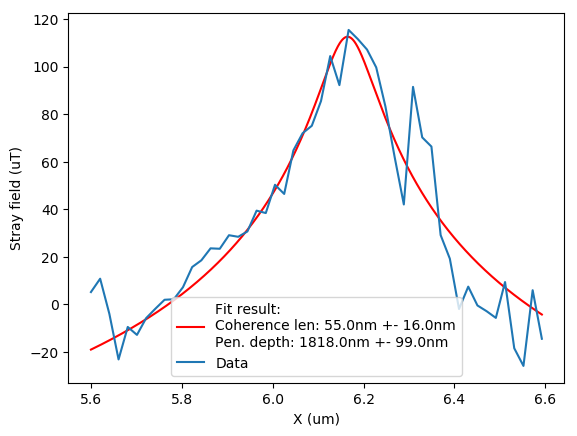

In [37]:
x = np.linspace(x_um_fit[0],x_um_fit[-1],1000, endpoint=True)
plt.plot(x, gmodel.eval(result.params, rho=x*1e-6)*1e6,'r-', label = f'Fit result: \n' 
         + f"Coherence len: {round(result.params['eta']*1e9,0)}nm +- {round(result.params['eta'].stderr*1e9,0)}nm\n"
        + f"Pen. depth: {round(result.params['lmda']*1e9,0)}nm +- {round(result.params['lmda'].stderr*1e9,0)}nm")

plt.plot(x_um_fit, field_fit*1e6, label='Data')
plt.xlabel('X (um)')
plt.ylabel('Stray field (uT)')

plt.legend()
plt.rcParams['figure.figsize'] = (9, 6)
fontsize = 12
# with open(filepath+f'_jupyter_plot_vortex_field_fit.png', 'wb') as f:
#     plt.savefig(f,format='png',dpi=400)


plt.show()

In [89]:
print(result.fit_report())

print(result.params['eta']*1e9, 'nm', ' +-', result.params['eta'].stderr*1e9, 'nm')
print(result.params['lmda']*1e9, 'nm', ' +-', result.params['lmda'].stderr*1e9, 'nm')

[[Model]]
    Model(vortex)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 50
    # variables        = 4
    chi-square         = 9.0293e-09
    reduced chi-square = 1.9629e-10
    Akaike info crit   = -1113.74060
    Bayesian info crit = -1106.09250
[[Variables]]
    delta_rho:  6.1649e-06 +/- 7.0995e-09 (0.12%) (init = 6.2e-06)
    eta:        5.5152e-08 +/- 1.5767e-08 (28.59%) (init = 1e-07)
    lmda:       1.8180e-06 +/- 9.8666e-08 (5.43%) (init = 2e-07)
    offset:    -1.6603e-04 +/- 1.5842e-05 (9.54%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(lmda, offset) =  0.967
    C(eta, lmda)    = -0.870
    C(eta, offset)  = -0.775

55.15151476167572 nm  +- 15.767277050058047 nm
1818.0165024469989 nm  +- 98.6664466623737 nm
